In [307]:
import torch
import logging
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import scipy.io as sio
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import PainRNN as PainRNN
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


folder_is = 'results_hdsz16_nepch5000'
param_is  = 'condition_prob_act-tanh_label-Actions'
model_is  = 'pain_rnn_tau_0.0010.pth'
mat_is    = 'InOutputs_condavg_prob.mat'
savedir   = os.path.join(os.getcwd(), folder_is, param_is, model_is[:-4] + '_silenced')
if not os.path.exists(savedir):
    os.makedirs(savedir)

load_mdl  = torch.load(os.path.join(os.getcwd(), folder_is, param_is, model_is))
load_mat  = sio.loadmat(os.path.join(os.getcwd(), mat_is))

inputs    = load_mat['Inputs']
inputs    = torch.from_numpy(np.expand_dims(inputs, axis = 2)).to(torch.float32)

In [308]:
n_conds = 9
n_times = inputs.size(1)
n_feats = load_mdl.hidden_size


outputs_silenced = []
for feat_i in range(n_feats):
    with torch.no_grad():
        outputs_original, hidden_units = load_mdl(inputs)
        
    hidden_units[:, :, feat_i] = 0  # Silence the unit
    output_silenced = []
    for time_i in range(n_times):
        output_silenced.append(load_mdl.h2o(hidden_units[:, time_i, :]))
        
    outputs_silenced.append(torch.stack(output_silenced, dim=1))
    
    with torch.no_grad():
        _, hidden_units = load_mdl(inputs)

outputs_silenced = torch.stack(outputs_silenced, dim=3)
sio.savemat(os.path.join(savedir, 'silenced_outputs_each_unit.mat'), 
    {'outputs_silenced': outputs_silenced.detach().numpy(), 
        'outputs_original': outputs_original.detach().numpy(),
        'hidden_units': hidden_units.detach().numpy()})

/var/folders/gp/xwr4jtsd6114drf2x6phz7wc0000gn/T/ipykernel_34994/1990127673.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_mtrx, method='ward')


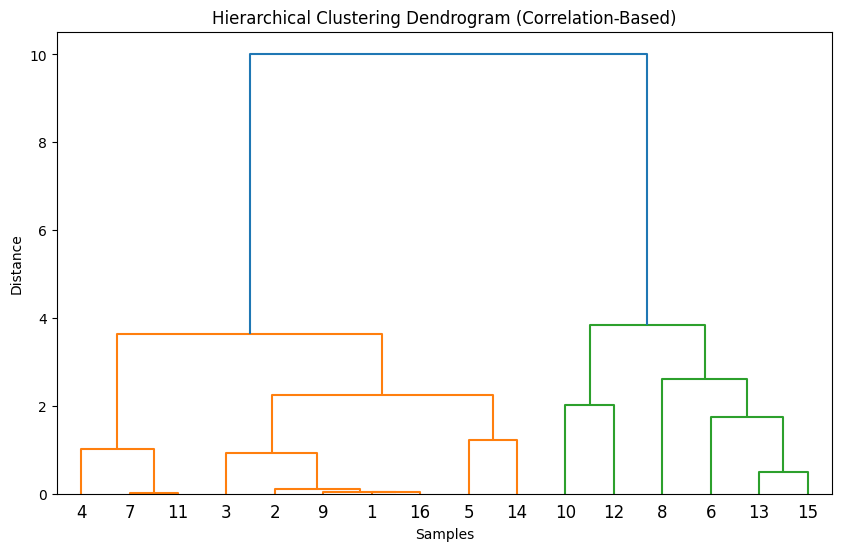

In [286]:
hiddens = hidden_units.detach().numpy()
n_conds, n_times, n_units = hiddens.shape

conds_hidden = []
for cond_i in range(n_conds):
    cond_hidden = hiddens[cond_i, :, :]
    conds_hidden.append(np.corrcoef(cond_hidden.T))

conds_hidden      = np.stack(conds_hidden, axis = 0)
conds_hidden_corr = conds_hidden.mean(axis = 0)
distance_mtrx     = 1 - conds_hidden_corr

linkage_matrix = sch.linkage(distance_mtrx, method='ward')

plt.figure(figsize=(10, 6))
sch.dendrogram(linkage_matrix, labels=[f'{i+1}' for i in range(linkage_matrix.shape[0] +1)])
plt.title('Hierarchical Clustering Dendrogram (Correlation-Based)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [288]:
silhouette_scores  = []
max_clusters = 10
for n_clusters in range(2, max_clusters + 1):
    labels = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    score = silhouette_score(distance_mtrx, labels, metric='precomputed')
    silhouette_scores.append(score)
    print(f"Clusters: {n_clusters} | Score: {score:.4f}")

optimal_clusters = np.argmax(silhouette_scores) + 2  # Offset by 2 (starts at 2 clusters)
print(f"Optimal clusters: {optimal_clusters}")
final_labels = sch.fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')

Clusters: 2 | Score: 0.5451
Clusters: 3 | Score: 0.4673
Clusters: 4 | Score: 0.4709
Clusters: 5 | Score: 0.4795
Clusters: 6 | Score: 0.5230
Clusters: 7 | Score: 0.5575
Clusters: 8 | Score: 0.5162
Clusters: 9 | Score: 0.4732
Clusters: 10 | Score: 0.4922
Optimal clusters: 7


In [306]:
n_conds = 9
n_times = inputs.size(1)
_, idx = np.unique(final_labels, return_index=True)
sorted_indices = np.sort(idx)
univals = final_labels[sorted_indices]
n_feats = len(univals)

outputs_silenced = []
for feat_i in range(n_feats):
    with torch.no_grad():
        outputs_original, hidden_units = load_mdl(inputs)
    omitidx = (final_labels  ==  univals[feat_i])
        
    hidden_units[:, :, feat_i] = 0  # Silence the unit
    output_silenced = []
    for time_i in range(n_times):
        output_silenced.append(load_mdl.h2o(hidden_units[:, time_i, :]))
        
    outputs_silenced.append(torch.stack(output_silenced, dim=1))
    
    with torch.no_grad():
        _, hidden_units = load_mdl(inputs)

outputs_silenced = torch.stack(outputs_silenced, dim=3)
sio.savemat(os.path.join(savedir, 'silenced_outputs_each_cluster.mat'), 
    {'outputs_silenced': outputs_silenced.detach().numpy(), 
        'outputs_original': outputs_original.detach().numpy(),
        'hidden_units': hidden_units.detach().numpy()})